# Wikipedia web-traffic competition
## Predicting time-series with ARIMA, Prophet and other machine learning models

### Importing all the libraries we will be using for visualization and training

In [1]:
import datetime
import re # to separate pages based on language (regular expression)
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # to visualize data

In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return pd.datetime.strptime(x, '%Y-%m-%d')

In [3]:
ts_zh = pd.read_csv('ts_zh.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
ts_fr = pd.read_csv('ts_fr.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
ts_en = pd.read_csv('ts_en.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
ts_na = pd.read_csv('ts_na.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
ts_ru = pd.read_csv('ts_ru.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
ts_de = pd.read_csv('ts_de.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
ts_ja = pd.read_csv('ts_ja.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
ts_es = pd.read_csv('ts_es.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [4]:
ts_dict =  {'zh': ts_zh,
            'fr': ts_fr,
            'en': ts_en,
            'na': ts_na,
            'ru': ts_ru,
            'de': ts_de,
            'ja': ts_ja,
            'es': ts_es}

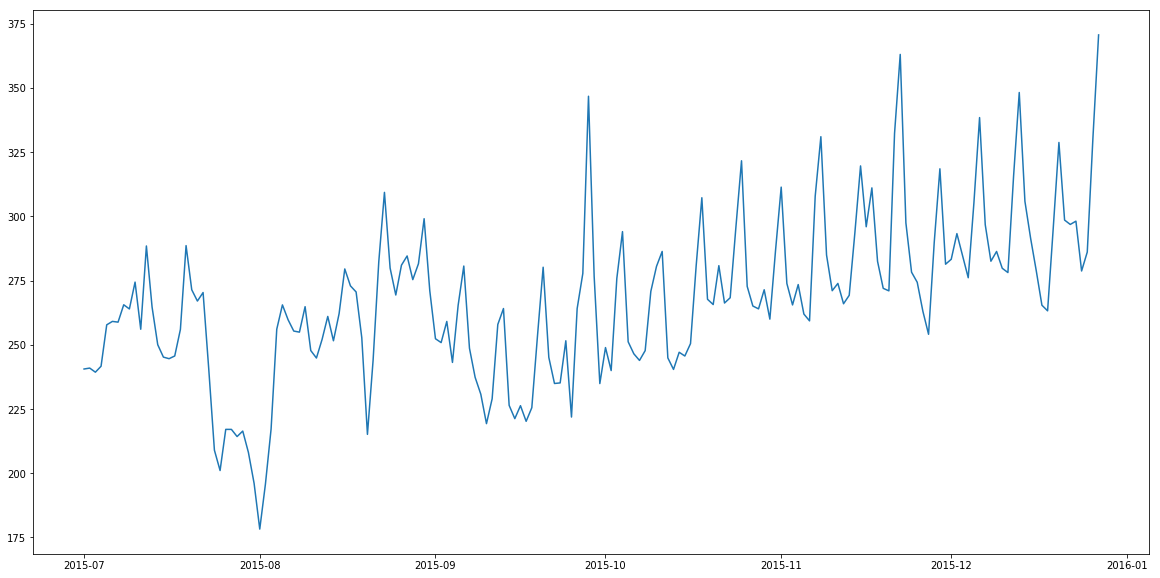

In [7]:
plt.figure(figsize=(20,10))
plt.plot(ts_zh[:180])


--------

# SINGLE-STEP PREDICTION

### Load data

In [22]:
import time
from math import sqrt
import numpy
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot


In [23]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, activation='relu'))
# 	model.add(Dense(2))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

### Global parameters

In [24]:
split_idx = -180

### Data preparation


 --- zh --- 

Test RMSE: 33.817


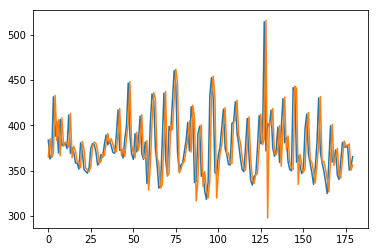


 --- fr --- 

Test RMSE: 63.507


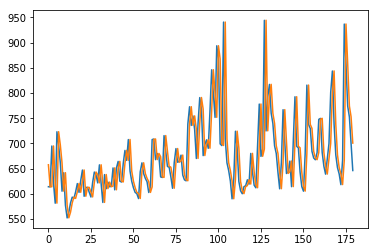


 --- en --- 

Test RMSE: 455.344


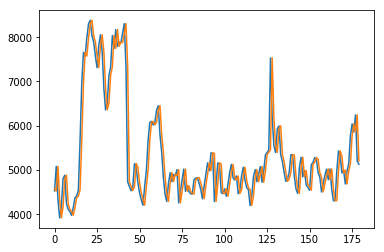


 --- na --- 

Test RMSE: 34.438


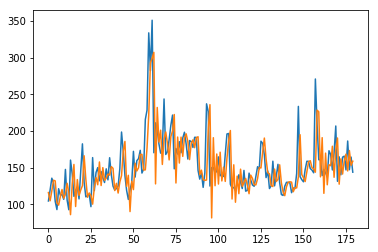


 --- ru --- 

Test RMSE: 187.202


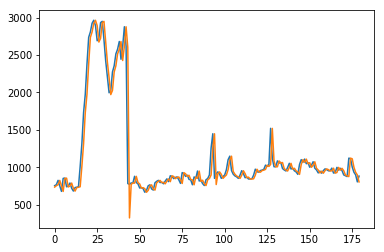


 --- de --- 

Test RMSE: 78.790


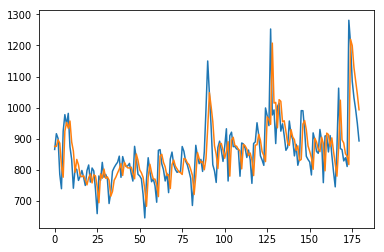


 --- ja --- 

Test RMSE: 91.716


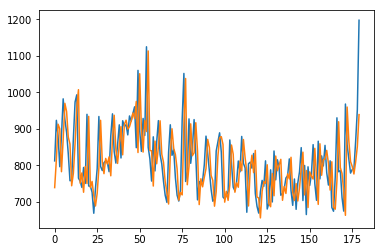


 --- es --- 

Test RMSE: 159.600


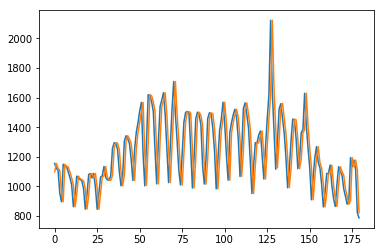

In [25]:
for key in ts_dict:

    # load dataset
    series = ts_dict[key]

    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)

    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    # split data into train and test-sets
    train, test = supervised_values[0:split_idx], supervised_values[split_idx:]

    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)

    # fit the model
    lstm_model = fit_lstm(train_scaled, batch_size=1, nb_epoch=1000, neurons=1)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    # train_reshaped.shape
    lstm_model.predict(train_reshaped, batch_size=1)
    
    # save the model
    model_json = lstm_model.to_json()
    file = open(key + '_lstm-model_trained.json', 'w')
    file.write(model_json)
    file.close()
    lstm_model.save_weights(key + '_lstm-model_trained.h5')

    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
    # 	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))                                                                 

    # report performance
    rmse = sqrt(mean_squared_error(raw_values[split_idx:], predictions))
    print('\n --- ' + key + ' --- \n')
    print('Test RMSE: %.3f' % rmse)
    # line plot of observed vs predicted
    pyplot.plot(raw_values[split_idx:])
    pyplot.plot(predictions)
    pyplot.show()
    pyplot.savefig(key + '_LSTM_prediction_graph.png')

In [28]:
r2_score(raw_values[split_idx:], predictions)

0.484554200987388

--------

# MULTI-STEP PREDICTION

### Load data

In [26]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.figure(figsize=(20,10))
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

t+1 RMSE: 15.359554
t+2 RMSE: 19.612202
t+3 RMSE: 17.244676

 --- zh --- 



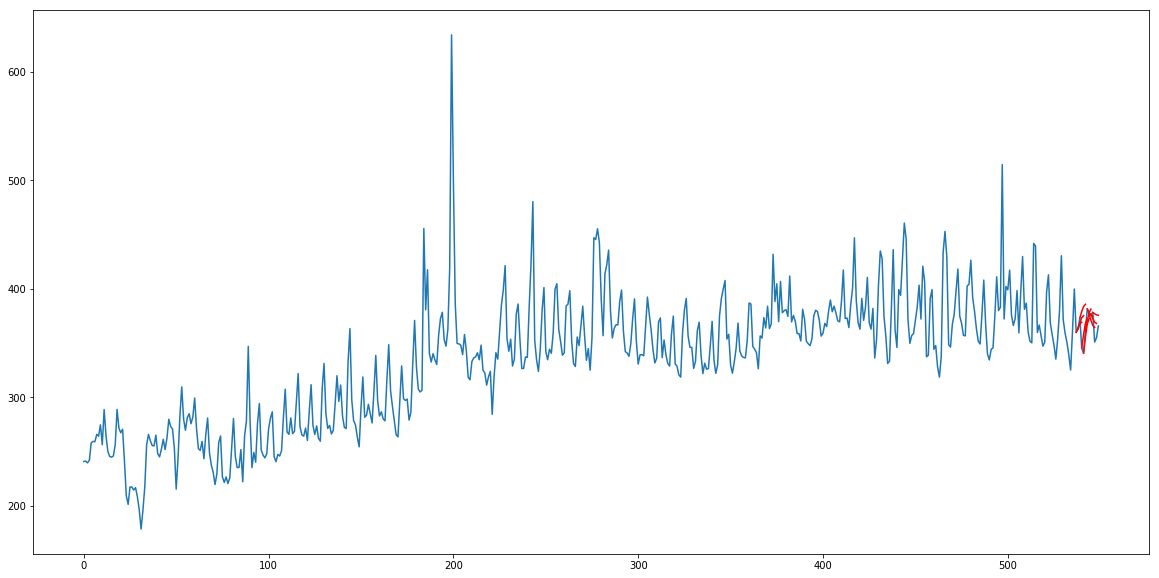

t+1 RMSE: 104.810247
t+2 RMSE: 140.382230
t+3 RMSE: 158.007637

 --- fr --- 



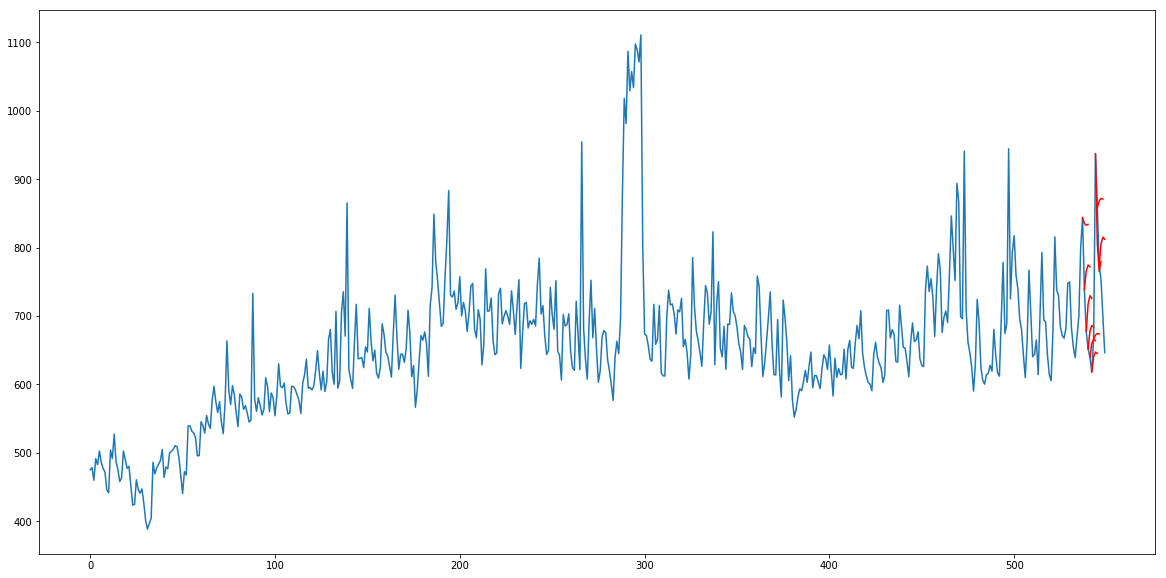

t+1 RMSE: 326.690270
t+2 RMSE: 456.188762
t+3 RMSE: 588.041690

 --- en --- 



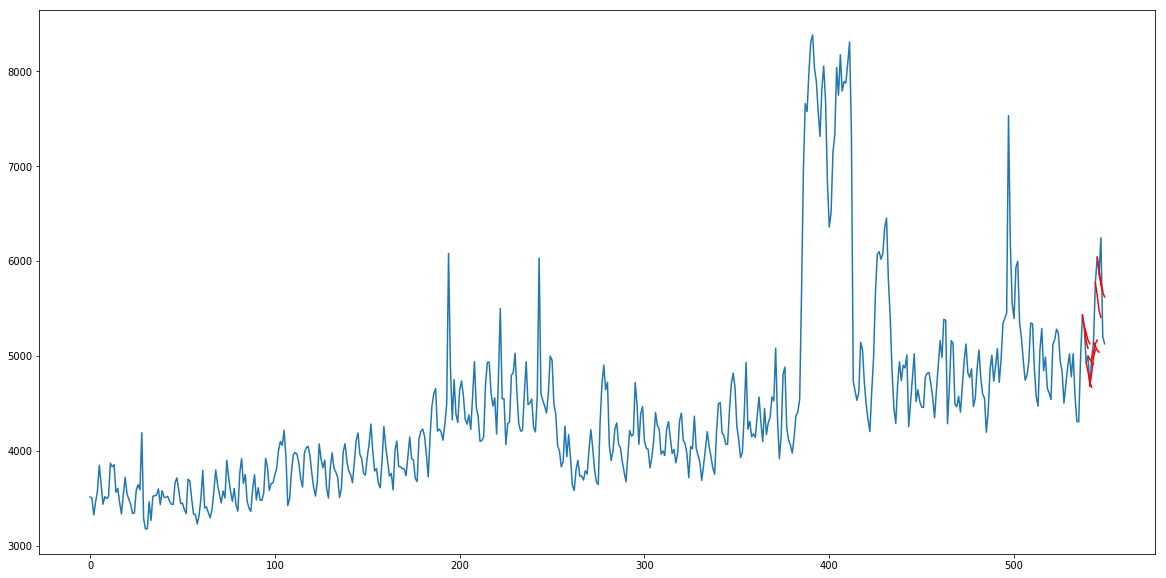

t+1 RMSE: 34.097217
t+2 RMSE: 28.486609
t+3 RMSE: 27.802990

 --- na --- 



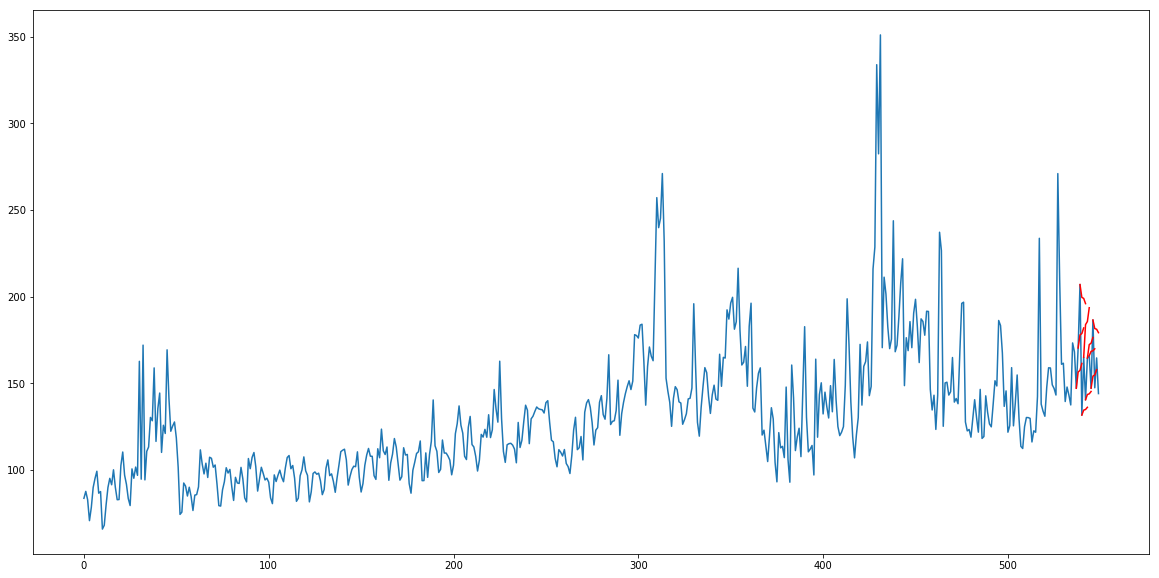

t+1 RMSE: 89.106181
t+2 RMSE: 141.800702
t+3 RMSE: 162.123542

 --- ru --- 



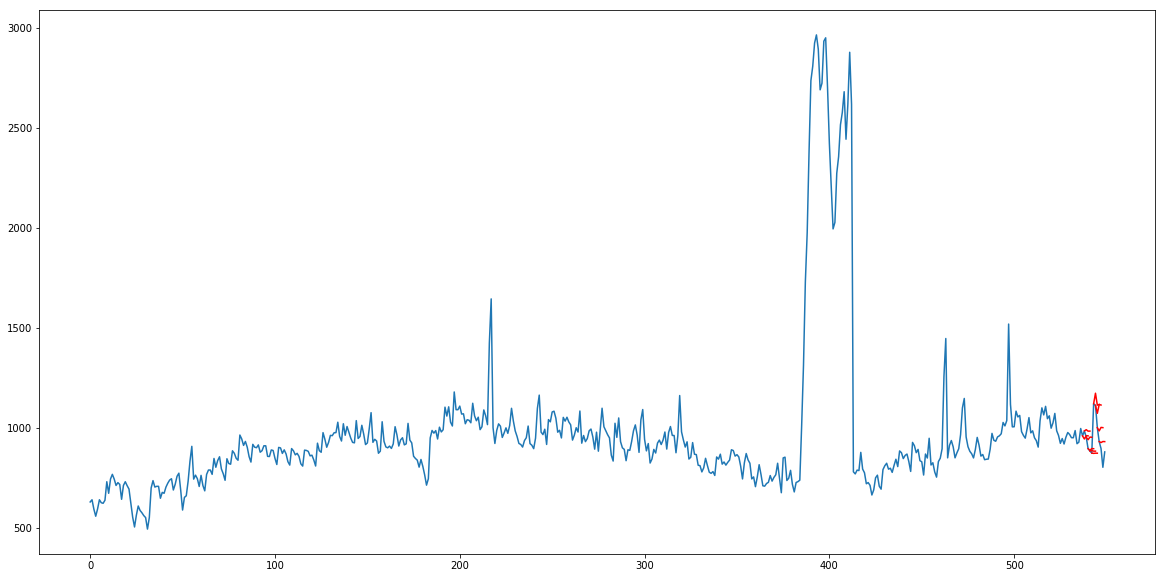

t+1 RMSE: 156.031116
t+2 RMSE: 205.120313
t+3 RMSE: 228.236948

 --- de --- 



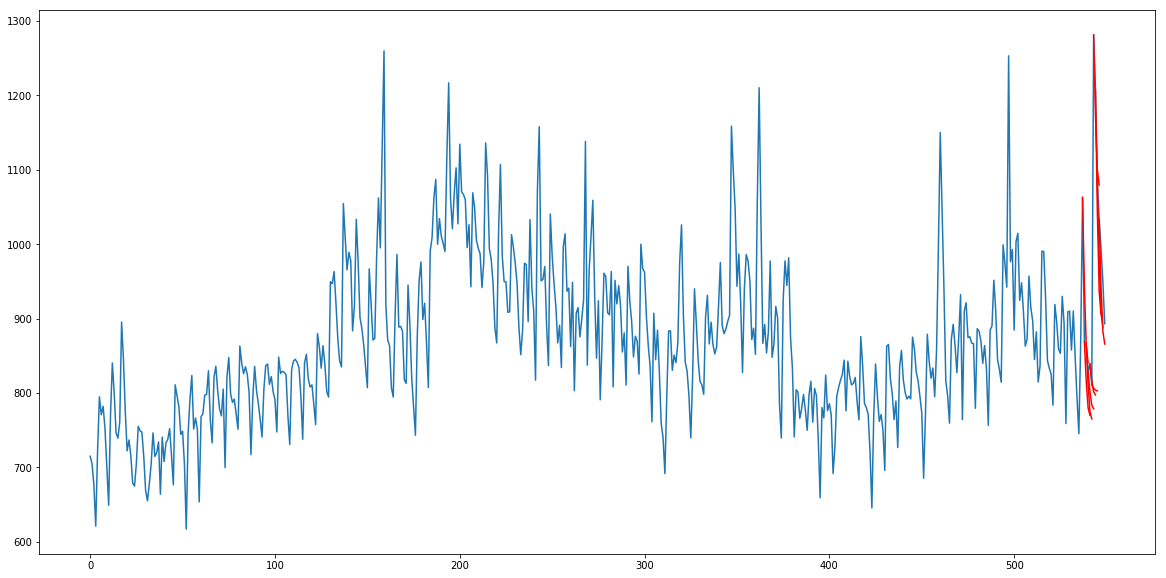

t+1 RMSE: 121.089337
t+2 RMSE: 156.171313
t+3 RMSE: 173.993158

 --- ja --- 



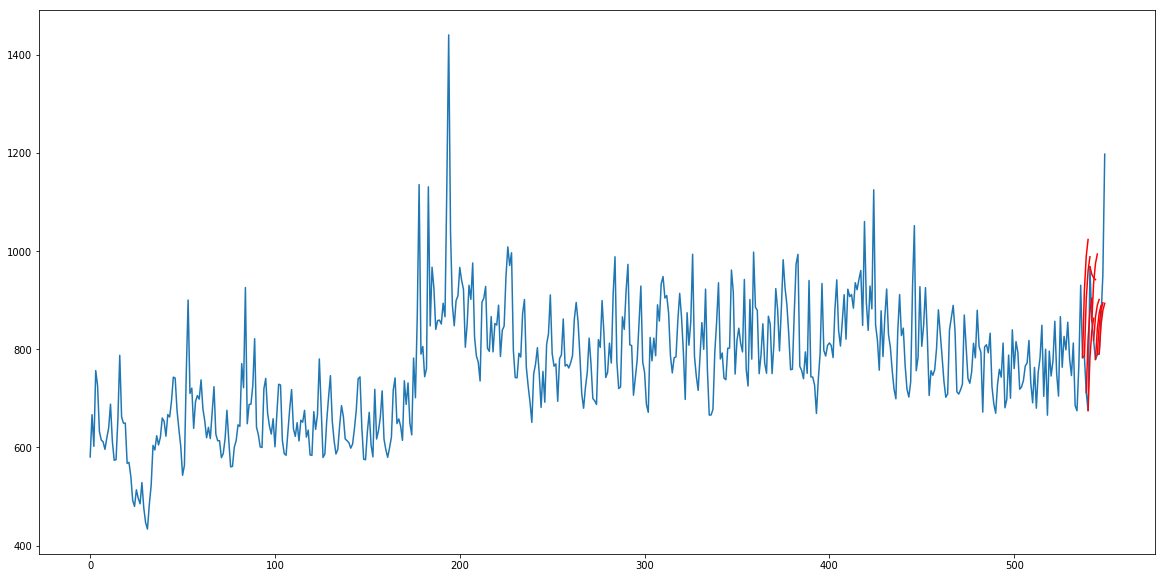

t+1 RMSE: 99.787307
t+2 RMSE: 130.103506
t+3 RMSE: 109.648065

 --- es --- 



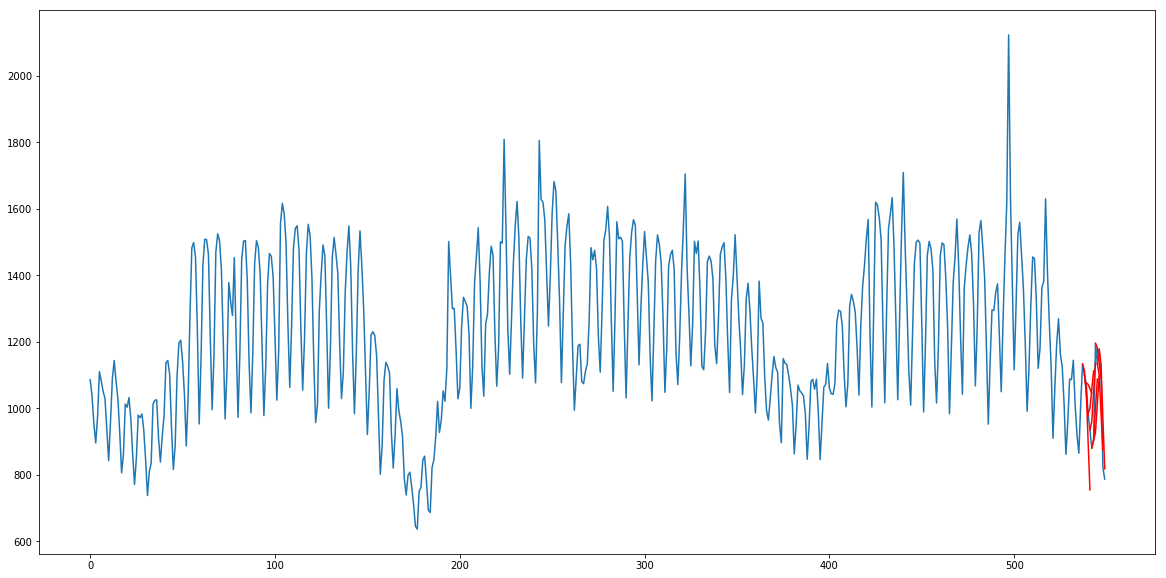

In [27]:
for key in ts_dict:
    
    # load dataset
    series = ts_dict[key]
    # configure
    n_lag = 3
    n_seq = 3
    n_test = 10
    n_epochs = 1000
    n_batch = 1
    n_neurons = 1
    # prepare data
    scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
    # fit model
    model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
    # save the model
    model_json = lstm_model.to_json()
    file = open(key + '_lstm-model_trained_multi-step.json', 'w')
    file.write(model_json)
    file.close()
    lstm_model.save_weights(key + '_lstm-model_trained_multi-step.h5')
    # make forecasts
    forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
    actual = [row[n_lag:] for row in test]
    actual = inverse_transform(series, actual, scaler, n_test+2)
    # evaluate forecasts
    evaluate_forecasts(actual, forecasts, n_lag, n_seq)
    # plot forecasts
    print('\n --- ' + key + ' --- \n')
    plot_forecasts(series, forecasts, n_test+2)
    pyplot.savefig(key + '_LSTM_prediction_graph_multi-step.png')